# create train and test set

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from geopandas.tools import geocode
import matplotlib.pyplot as plt
import gc

In [2]:
years = list(np.arange(2010, 2019))

In [3]:
def process_ecv(outbreaks_data, evc_data, ecv):
    
    """
    This functions resamples given ecv data to the district level with an inner spatial join, using the within criterion.
    It then calculates the areal mean of the ecv as well as one and two month lagged means.
    Finally, it drops rows with missing values and returns a geodataframe.    
    """
    
    outbreaks_ecv = gpd.sjoin(evc_data, outbreaks_data[['district', 'geometry']], how='inner', op='within').reset_index(drop=True)
    outbreaks_ecv = outbreaks_ecv.drop('index_right', axis=1)
    
    outbreaks_ecv = outbreaks_ecv.groupby(['district', 'year', 'month']).aggregate('mean').reset_index()
    
    outbreaks_ecv[ecv+'_lag_1'] = outbreaks_ecv.groupby(['district'])[ecv].shift(1)
    outbreaks_ecv[ecv+'_lag_2'] = outbreaks_ecv.groupby(['district'])[ecv].shift(2)
    
    outbreaks_ecv = outbreaks_ecv.dropna()
    
    return outbreaks_ecv

## outbreaks

In [4]:
outbreaks = gpd.read_file('../data/cholera_outbreaks/monthly_cholera_outbreaks_per_district_2010_2015.shp')

In [5]:
outbreaks.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
outbreaks.shape

(466, 6)

In [7]:
outbreaks.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 466 entries, 0 to 465
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   state     466 non-null    object  
 1   district  466 non-null    object  
 2   year      466 non-null    int64   
 3   month     466 non-null    int64   
 4   outbreak  466 non-null    int64   
 5   geometry  466 non-null    geometry
dtypes: geometry(1), int64(3), object(2)
memory usage: 22.0+ KB


In [8]:
outbreaks.head()

,state,district,year,month,outbreak,geometry
0,himachal pradesh,shimla,2010,7,1,"POLYGON ((77.51051 30.78743, 77.50089 30.79253..."
1,rajasthan,alwar,2010,7,1,"POLYGON ((76.45745 27.08288, 76.44963 27.08627..."
2,assam,dibrugarh,2010,9,1,"POLYGON ((95.37698 27.10218, 95.37267 27.10167..."
3,karnataka,belgaum,2010,9,1,"POLYGON ((74.75089 15.49199, 74.74472 15.48939..."
4,gujarat,bharuch,2010,9,1,"MULTIPOLYGON (((72.67597 21.44681, 72.67597 21..."


In [9]:
# reproject crs to https://epsg.io/7755
outbreaks = outbreaks.to_crs(epsg=7755)

In [10]:
outbreaks.crs

<Projected CRS: EPSG:7755>
Name: WGS 84 / India NSF LCC
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: India - onshore and offshore. Includes Amandivis, Laccadives, Minicoy, Andaman Islands, Nicobar Islands, and Sikkim.
- bounds: (65.6, 3.87, 97.42, 35.51)
Coordinate Operation:
- name: Survey of India Lambert
- method: Lambert Conic Conformal (2SP)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
outbreaks['geometry'] = outbreaks['geometry'].buffer(111000)

In [12]:
outbreaks.head()

,state,district,year,month,outbreak,geometry
0,himachal pradesh,shimla,2010,7,1,"POLYGON ((3764447.443 4629412.289, 3756506.279..."
1,rajasthan,alwar,2010,7,1,"POLYGON ((3511741.355 4351422.986, 3511461.882..."
2,assam,dibrugarh,2010,9,1,"POLYGON ((5480598.578 4308612.598, 5470976.881..."
3,karnataka,belgaum,2010,9,1,"POLYGON ((3511024.973 2988369.571, 3508809.558..."
4,gujarat,bharuch,2010,9,1,"POLYGON ((3128676.356 3764922.012, 3128624.344..."


## resampling ecvs at district level and feature creation

### sea surface salinity

In [13]:
path = '../data/sea_surface_salinity'

In [14]:
file = 'monthly_sss_'+str(years[0])+'.shp'

In [15]:
sss = gpd.read_file(os.path.join(path, file))

In [16]:
sss.crs == outbreaks.crs

False

In [17]:
sss = sss.to_crs(epsg=7755)

In [18]:
sss.crs == outbreaks.crs

True

In [19]:
sss.shape

(151452, 4)

In [20]:
sss.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 151452 entries, 0 to 151451
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   year      151452 non-null  int64   
 1   month     151452 non-null  int64   
 2   sss       151452 non-null  float64 
 3   geometry  151452 non-null  geometry
dtypes: float64(1), geometry(1), int64(2)
memory usage: 4.6 MB


In [21]:
sss.head()

,year,month,sss,geometry
0,2010,1,35.265869,POINT (1638970.593 1499981.689)
1,2010,2,35.191532,POINT (1638970.593 1499981.689)
2,2010,3,35.426231,POINT (1638970.593 1499981.689)
3,2010,4,35.370430,POINT (1638970.593 1499981.689)
4,2010,5,35.310860,POINT (1638970.593 1499981.689)


In [22]:
sss_district_level = pd.DataFrame(columns=['district', 'year', 'month', 'sss', 'sss_lag_1', 'sss_lag_2'])

In [23]:
%%time

for year in years:
    print('Processing {}...'.format(year))
    sss = gpd.read_file(os.path.join(path, 'monthly_sss_'+str(year)+'.shp'))
    sss = sss.to_crs(epsg=7755)
    sss_district_level_temp = process_ecv(outbreaks, sss, 'sss')
    sss_district_level = sss_district_level.append(sss_district_level_temp)

Processing 2010...
Processing 2011...
Processing 2012...
Processing 2013...
Processing 2014...
Processing 2015...
Processing 2016...
Processing 2017...
Processing 2018...
CPU times: user 4min 49s, sys: 752 ms, total: 4min 49s
Wall time: 4min 49s


In [24]:
sss_district_level.shape

(4590, 6)

In [25]:
sss_district_level.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4590 entries, 2 to 611
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   district   4590 non-null   object 
 1   year       4590 non-null   object 
 2   month      4590 non-null   object 
 3   sss        4590 non-null   float64
 4   sss_lag_1  4590 non-null   float64
 5   sss_lag_2  4590 non-null   float64
dtypes: float64(3), object(3)
memory usage: 251.0+ KB


In [26]:
sss_district_level.head()

,district,year,month,sss,sss_lag_1,sss_lag_2
2,belgaum,2010,3,34.027400,34.600696,35.335807
3,belgaum,2010,4,34.299124,34.027400,34.600696
4,belgaum,2010,5,34.924089,34.299124,34.027400
5,belgaum,2010,6,35.246572,34.924089,34.299124
6,belgaum,2010,7,35.282390,35.246572,34.924089


In [27]:
del [sss, sss_district_level_temp]
gc.collect()

556

### chlorophyll-a concentration

In [28]:
path = '../data/chlorophyll_a_concentration'

In [29]:
file = 'monthly_chlor_a_'+str(years[0])+'.shp'

In [30]:
chlor_a = gpd.read_file(os.path.join(path, file))

In [31]:
chlor_a.crs == outbreaks.crs

False

In [32]:
chlor_a = chlor_a.to_crs(epsg=7755)

In [33]:
chlor_a.crs == outbreaks.crs

True

In [34]:
chlor_a.shape

(4933904, 4)

In [35]:
chlor_a.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4933904 entries, 0 to 4933903
Data columns (total 4 columns):
 #   Column    Dtype   
---  ------    -----   
 0   year      int64   
 1   month     int64   
 2   chlor_a   float64 
 3   geometry  geometry
dtypes: float64(1), geometry(1), int64(2)
memory usage: 150.6 MB


In [36]:
chlor_a.head()

,year,month,chlor_a,geometry
0,2010,1,-2.034988,POINT (1635051.143 1491337.847)
1,2010,2,-1.678654,POINT (1635051.143 1491337.847)
2,2010,3,-1.910417,POINT (1635051.143 1491337.847)
3,2010,4,-2.278393,POINT (1635051.143 1491337.847)
4,2010,5,-2.353248,POINT (1635051.143 1491337.847)


In [37]:
chlor_a_district_level = pd.DataFrame(columns=['district', 'year', 'month', 'chlor_a', 'chlor_a_lag_1', 'chlor_a_lag_2'])

In [38]:
%%time

for year in years:
    print('Processing {}...'.format(year))
    chlor_a = gpd.read_file(os.path.join(path, 'monthly_chlor_a_'+str(year)+'.shp'))
    chlor_a = chlor_a.to_crs(epsg=7755)
    chlor_a_district_level_temp = process_ecv(outbreaks, chlor_a, 'chlor_a')
    chlor_a_district_level = chlor_a_district_level.append(chlor_a_district_level_temp)

Processing 2010...
Processing 2011...
Processing 2012...
Processing 2013...
Processing 2014...
Processing 2015...
Processing 2016...
Processing 2017...
Processing 2018...
CPU times: user 2h 19min 52s, sys: 35 s, total: 2h 20min 27s
Wall time: 2h 20min 36s


In [39]:
chlor_a_district_level.shape

(6015, 6)

In [40]:
chlor_a_district_level.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6015 entries, 2 to 770
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   district       6015 non-null   object 
 1   year           6015 non-null   object 
 2   month          6015 non-null   object 
 3   chlor_a        6015 non-null   float64
 4   chlor_a_lag_1  6015 non-null   float64
 5   chlor_a_lag_2  6015 non-null   float64
dtypes: float64(3), object(3)
memory usage: 328.9+ KB


In [41]:
chlor_a_district_level.head()

,district,year,month,chlor_a,chlor_a_lag_1,chlor_a_lag_2
2,ahmadabad,2010,3,2.260830,2.251449,2.406572
3,ahmadabad,2010,4,2.274136,2.260830,2.251449
4,ahmadabad,2010,5,2.110336,2.274136,2.260830
5,ahmadabad,2010,6,2.239608,2.110336,2.274136
6,ahmadabad,2010,7,2.183196,2.239608,2.110336


In [42]:
del [chlor_a, chlor_a_district_level_temp]
gc.collect()

731

### land surface temperature

In [43]:
path = '../data/land_surface_temperature'

In [44]:
file = 'monthly_lst_'+str(years[0])+'.shp'

In [45]:
lst = gpd.read_file(os.path.join(path, file))

In [46]:
lst.crs == outbreaks.crs

False

In [47]:
lst = lst.to_crs(epsg=7755)

In [48]:
lst.crs == outbreaks.crs

True

In [49]:
lst.shape

(3364371, 4)

In [50]:
lst.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3364371 entries, 0 to 3364370
Data columns (total 4 columns):
 #   Column    Dtype   
---  ------    -----   
 0   year      int64   
 1   month     int64   
 2   lst       float64 
 3   geometry  geometry
dtypes: float64(1), geometry(1), int64(2)
memory usage: 102.7 MB


In [51]:
lst.head()

,year,month,lst,geometry
0,2010,3,298.179993,POINT (6105450.505 1456856.677)
1,2010,4,263.160004,POINT (6105450.505 1456856.677)
2,2010,7,292.839996,POINT (6105450.505 1456856.677)
3,2010,8,281.899994,POINT (6105450.505 1456856.677)
4,2010,11,251.569992,POINT (6105450.505 1456856.677)


In [52]:
lst_district_level = pd.DataFrame(columns=['district', 'year', 'month', 'lst', 'lst_lag_1', 'lst_lag_2'])

In [53]:
%%time

for year in years:
    print('Processing {}...'.format(year))
    lst = gpd.read_file(os.path.join(path, 'monthly_lst_'+str(year)+'.shp'))
    lst = lst.to_crs(epsg=7755)
    lst_district_level_temp = process_ecv(outbreaks, lst, 'lst')
    lst_district_level = lst_district_level.append(lst_district_level_temp)

Processing 2010...
Processing 2011...
Processing 2012...
Processing 2013...
Processing 2014...
Processing 2015...
Processing 2016...
Processing 2017...
Processing 2018...
CPU times: user 2h 7min 4s, sys: 54.7 s, total: 2h 7min 58s
Wall time: 2h 8min 4s


In [54]:
lst_district_level.shape

(15587, 6)

In [55]:
lst_district_level.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15587 entries, 2 to 2093
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   district   15587 non-null  object 
 1   year       15587 non-null  object 
 2   month      15587 non-null  object 
 3   lst        15587 non-null  float64
 4   lst_lag_1  15587 non-null  float64
 5   lst_lag_2  15587 non-null  float64
dtypes: float64(3), object(3)
memory usage: 852.4+ KB


In [56]:
lst_district_level.head()

,district,year,month,lst,lst_lag_1,lst_lag_2
2,ahmadabad,2010,3,325.963631,318.111811,313.017665
3,ahmadabad,2010,4,329.984802,325.963631,318.111811
4,ahmadabad,2010,5,334.093161,329.984802,325.963631
5,ahmadabad,2010,6,329.799811,334.093161,329.984802
6,ahmadabad,2010,7,275.639148,329.799811,334.093161


In [57]:
del [lst, lst_district_level_temp]
gc.collect()

417

## join features and target

In [58]:
outbreaks[['district', 'geometry']].drop_duplicates().shape

(178, 2)

In [59]:
train_test_sss = pd.merge(outbreaks[['district', 'geometry']].drop_duplicates(), sss_district_level, how='inner', on='district')

In [60]:
train_test_sss.shape

(4590, 7)

In [61]:
train_test_chlor_a = pd.merge(outbreaks[['district', 'geometry']].drop_duplicates(), chlor_a_district_level, how='inner', on='district')

In [62]:
train_test_chlor_a.shape

(6015, 7)

In [63]:
train_test_lst = pd.merge(outbreaks[['district', 'geometry']].drop_duplicates(), lst_district_level, how='inner', on='district')

In [64]:
train_test_lst.shape

(15587, 7)

In [65]:
train_test = pd.merge(train_test_sss, train_test_chlor_a.drop('geometry', axis=1), how='inner', on=['district', 'year', 'month'])
train_test = pd.merge(train_test, train_test_lst.drop('geometry', axis=1), how='inner', on=['district', 'year', 'month'])
train_test = pd.merge(train_test, outbreaks[['district', 'year', 'month', 'outbreak']], how='left', on=['district', 'year', 'month']).reset_index(drop=True)

In [66]:
train_test.shape

(4325, 14)

In [67]:
train_test.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4325 entries, 0 to 4324
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   district       4325 non-null   object  
 1   geometry       4325 non-null   geometry
 2   year           4325 non-null   object  
 3   month          4325 non-null   object  
 4   sss            4325 non-null   float64 
 5   sss_lag_1      4325 non-null   float64 
 6   sss_lag_2      4325 non-null   float64 
 7   chlor_a        4325 non-null   float64 
 8   chlor_a_lag_1  4325 non-null   float64 
 9   chlor_a_lag_2  4325 non-null   float64 
 10  lst            4325 non-null   float64 
 11  lst_lag_1      4325 non-null   float64 
 12  lst_lag_2      4325 non-null   float64 
 13  outbreak       109 non-null    float64 
dtypes: float64(10), geometry(1), object(3)
memory usage: 473.2+ KB


In [68]:
train_test['outbreak'] = train_test['outbreak'].fillna(0)

In [69]:
train_test['outbreak'].value_counts()

0.0    4216
1.0     109
Name: outbreak, dtype: int64

In [70]:
train_test

,district,geometry,year,month,sss,sss_lag_1,sss_lag_2,chlor_a,chlor_a_lag_1,chlor_a_lag_2,lst,lst_lag_1,lst_lag_2,outbreak
0,belgaum,"POLYGON ((3511024.973 2988369.571, 3508809.558...",2010,3,34.027400,34.600696,35.335807,-0.503310,-0.470824,-0.067947,326.305884,320.030061,314.014733,0.0
1,belgaum,"POLYGON ((3511024.973 2988369.571, 3508809.558...",2010,4,34.299124,34.027400,34.600696,-0.573133,-0.503310,-0.470824,330.424175,326.305884,320.030061,0.0
2,belgaum,"POLYGON ((3511024.973 2988369.571, 3508809.558...",2010,5,34.924089,34.299124,34.027400,-0.488359,-0.573133,-0.503310,332.450231,330.424175,326.305884,0.0
3,belgaum,"POLYGON ((3511024.973 2988369.571, 3508809.558...",2010,6,35.246572,34.924089,34.299124,-0.147612,-0.488359,-0.573133,313.549617,332.450231,330.424175,0.0
4,belgaum,"POLYGON ((3511024.973 2988369.571, 3508809.558...",2010,7,35.282390,35.246572,34.924089,0.279714,-0.147612,-0.488359,304.003108,313.549617,332.450231,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4320,pathanamthitta,"POLYGON ((3511537.740 2452350.639, 3511765.621...",2018,8,33.805684,34.235850,34.611369,1.352465,-0.149383,-0.081882,319.462127,316.543710,309.711798,0.0
4321,pathanamthitta,"POLYGON ((3511537.740 2452350.639, 3511765.621...",2018,9,34.660524,33.805684,34.235850,0.699136,1.352465,-0.149383,322.904377,319.462127,316.543710,0.0
4322,pathanamthitta,"POLYGON ((3511537.740 2452350.639, 3511765.621...",2018,10,35.295586,34.660524,33.805684,-0.742611,0.699136,1.352465,312.129742,322.904377,319.462127,0.0
4323,pathanamthitta,"POLYGON ((3511537.740 2452350.639, 3511765.621...",2018,11,35.153257,35.295586,34.660524,-1.140299,-0.742611,0.699136,308.569854,312.129742,322.904377,0.0


## map district to location

In [71]:
cape_comorin = geocode('Cape Comorin', provider='nominatim', user_agent='cholera_risk_modeling', timeout=4)

In [72]:
cape_comorin.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [73]:
cape_comorin

,geometry,address
0,POINT (77.55138 8.07729),"Cape Comorin, Vavaturai, Agastheeswaram, Kanya..."


In [74]:
cape_comorin = cape_comorin.to_crs(epsg=7755)

In [75]:
cape_comorin.crs

<Projected CRS: EPSG:7755>
Name: WGS 84 / India NSF LCC
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: India - onshore and offshore. Includes Amandivis, Laccadives, Minicoy, Andaman Islands, Nicobar Islands, and Sikkim.
- bounds: (65.6, 3.87, 97.42, 35.51)
Coordinate Operation:
- name: Survey of India Lambert
- method: Lambert Conic Conformal (2SP)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [76]:
split_point = cape_comorin.loc[0, 'geometry']

In [77]:
print(split_point)

POINT (3725305.123427642 2252761.855500367)


In [78]:
split_point.x

3725305.1234276416

In [79]:
split_point.y

2252761.8555003675

In [80]:
train_test.crs

<Projected CRS: EPSG:7755>
Name: WGS 84 / India NSF LCC
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: India - onshore and offshore. Includes Amandivis, Laccadives, Minicoy, Andaman Islands, Nicobar Islands, and Sikkim.
- bounds: (65.6, 3.87, 97.42, 35.51)
Coordinate Operation:
- name: Survey of India Lambert
- method: Lambert Conic Conformal (2SP)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [81]:
train_test['centroid'] = train_test.centroid

In [82]:
train_test['location'] = train_test.apply(lambda x: 'west' if x['centroid'].x < split_point.x else 'east', axis=1)

In [83]:
train_test.head()

,district,geometry,year,month,sss,sss_lag_1,sss_lag_2,chlor_a,chlor_a_lag_1,chlor_a_lag_2,lst,lst_lag_1,lst_lag_2,outbreak,centroid,location
0,belgaum,"POLYGON ((3511024.973 2988369.571, 3508809.558...",2010,3,34.027400,34.600696,35.335807,-0.503310,-0.470824,-0.067947,326.305884,320.030061,314.014733,0.0,POINT (3452573.951 3155966.274),west
1,belgaum,"POLYGON ((3511024.973 2988369.571, 3508809.558...",2010,4,34.299124,34.027400,34.600696,-0.573133,-0.503310,-0.470824,330.424175,326.305884,320.030061,0.0,POINT (3452573.951 3155966.274),west
2,belgaum,"POLYGON ((3511024.973 2988369.571, 3508809.558...",2010,5,34.924089,34.299124,34.027400,-0.488359,-0.573133,-0.503310,332.450231,330.424175,326.305884,0.0,POINT (3452573.951 3155966.274),west
3,belgaum,"POLYGON ((3511024.973 2988369.571, 3508809.558...",2010,6,35.246572,34.924089,34.299124,-0.147612,-0.488359,-0.573133,313.549617,332.450231,330.424175,0.0,POINT (3452573.951 3155966.274),west
4,belgaum,"POLYGON ((3511024.973 2988369.571, 3508809.558...",2010,7,35.282390,35.246572,34.924089,0.279714,-0.147612,-0.488359,304.003108,313.549617,332.450231,0.0,POINT (3452573.951 3155966.274),west


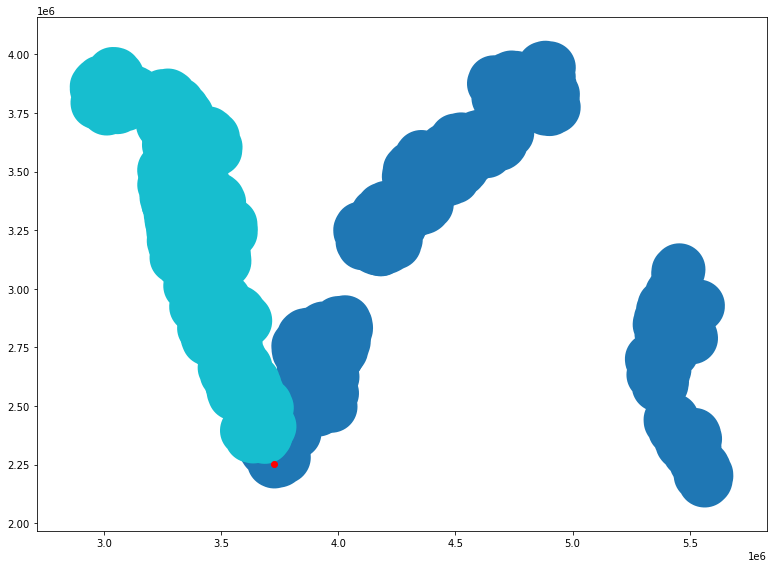

In [84]:
fig, ax = plt.subplots(figsize=(12,8))

train_test[['geometry', 'location']].drop_duplicates().plot(ax=ax, column='location')

cape_comorin.plot(ax=ax, color='red')

plt.tight_layout()

In [85]:
train_test = train_test.drop('centroid', axis=1)

## map month to season

In [86]:
seasons = {1: 'winter',
           2: 'winter',
           3: 'pre_monsoon',
           4: 'pre_monsoon',
           5: 'pre_monsoon',
           6: 'monsoon',
           7: 'monsoon',
           8: 'monsoon',
           9: 'monsoon',
           10: 'post_monsoon',
           11: 'post_monsoon',
           12: 'post_monsoon'}

In [87]:
train_test['season'] = train_test['month'].map(seasons)

In [88]:
train_test.head()

,district,geometry,year,month,sss,sss_lag_1,sss_lag_2,chlor_a,chlor_a_lag_1,chlor_a_lag_2,lst,lst_lag_1,lst_lag_2,outbreak,location,season
0,belgaum,"POLYGON ((3511024.973 2988369.571, 3508809.558...",2010,3,34.027400,34.600696,35.335807,-0.503310,-0.470824,-0.067947,326.305884,320.030061,314.014733,0.0,west,pre_monsoon
1,belgaum,"POLYGON ((3511024.973 2988369.571, 3508809.558...",2010,4,34.299124,34.027400,34.600696,-0.573133,-0.503310,-0.470824,330.424175,326.305884,320.030061,0.0,west,pre_monsoon
2,belgaum,"POLYGON ((3511024.973 2988369.571, 3508809.558...",2010,5,34.924089,34.299124,34.027400,-0.488359,-0.573133,-0.503310,332.450231,330.424175,326.305884,0.0,west,pre_monsoon
3,belgaum,"POLYGON ((3511024.973 2988369.571, 3508809.558...",2010,6,35.246572,34.924089,34.299124,-0.147612,-0.488359,-0.573133,313.549617,332.450231,330.424175,0.0,west,monsoon
4,belgaum,"POLYGON ((3511024.973 2988369.571, 3508809.558...",2010,7,35.282390,35.246572,34.924089,0.279714,-0.147612,-0.488359,304.003108,313.549617,332.450231,0.0,west,monsoon


## make dummies from categorical features

In [89]:
location_dummies = pd.get_dummies(train_test['location'], prefix='location', prefix_sep='_')

In [90]:
train_test = pd.concat([train_test, location_dummies], axis=1).drop('location', axis=1)

In [91]:
season_dummies = pd.get_dummies(train_test['season'], prefix='season', prefix_sep='_')

In [92]:
train_test = pd.concat([train_test, season_dummies], axis=1).drop('season', axis=1)

In [93]:
train_test.head()

,district,geometry,year,month,sss,sss_lag_1,sss_lag_2,chlor_a,chlor_a_lag_1,chlor_a_lag_2,lst,lst_lag_1,lst_lag_2,outbreak,location_east,location_west,season_monsoon,season_post_monsoon,season_pre_monsoon
0,belgaum,"POLYGON ((3511024.973 2988369.571, 3508809.558...",2010,3,34.027400,34.600696,35.335807,-0.503310,-0.470824,-0.067947,326.305884,320.030061,314.014733,0.0,0,1,0,0,1
1,belgaum,"POLYGON ((3511024.973 2988369.571, 3508809.558...",2010,4,34.299124,34.027400,34.600696,-0.573133,-0.503310,-0.470824,330.424175,326.305884,320.030061,0.0,0,1,0,0,1
2,belgaum,"POLYGON ((3511024.973 2988369.571, 3508809.558...",2010,5,34.924089,34.299124,34.027400,-0.488359,-0.573133,-0.503310,332.450231,330.424175,326.305884,0.0,0,1,0,0,1
3,belgaum,"POLYGON ((3511024.973 2988369.571, 3508809.558...",2010,6,35.246572,34.924089,34.299124,-0.147612,-0.488359,-0.573133,313.549617,332.450231,330.424175,0.0,0,1,1,0,0
4,belgaum,"POLYGON ((3511024.973 2988369.571, 3508809.558...",2010,7,35.282390,35.246572,34.924089,0.279714,-0.147612,-0.488359,304.003108,313.549617,332.450231,0.0,0,1,1,0,0


## save final geodataframe

In [94]:
train_test.to_file('../data/train_test.shp')